In [25]:
import gym
from gym import spaces, logger
from gym.utils import seeding

import numpy as np
import os
import random
import math

import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras.losses import huber_loss
from keras import backend as K

import torch

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [26]:
#Task 3
class CartPoleEnv3(gym.Env):
	metadata = {
			'render.modes': ['human', 'rgb_array'],
			'video.frames_per_second' : 50
	}

	def __init__(self,case=1):
		self.__version__ = "0.2.0"
		print("CartPoleEnv - Version {}, Noise case: {}".format(self.__version__,case))
		self.gravity = 9.8
		self.masscart = 1.0
		self.masspole = 0.4
		self.total_mass = (self.masspole + self.masscart)
		self.length = 0.5 
		self.polemass_length = (self.masspole * self.length)
		self._seed()

		#self.force_mag = 10.0
		self.force_mag = 10.0*(1+self.np_random.uniform(low=-0.30, high=0.30))

		 
		self.tau = 0.02  # seconds between state updates
		self.frictioncart = 5e-4 # AA Added cart friction
		self.frictionpole = 2e-6 # AA Added cart friction
		self.gravity_eps = 0.99 # Random scaling for gravity
		self.frictioncart_eps = 0.99 # Random scaling for friction
		self.frictionpole_eps = 0.99 # Random scaling for friction

		# Angle at which to fail the episode
		self.theta_threshold_radians = 12 * 2 * math.pi / 360
		self.x_threshold = 2.4

		# Angle limit set to 2 * theta_threshold_radians so failing observation is still within bounds
		high = np.array([
			self.x_threshold * 2,
			np.finfo(np.float32).max,
			self.theta_threshold_radians * 2,
			np.finfo(np.float32).max])

		self.action_space = spaces.Discrete(2) # AA Set discrete states back to 2
		self.observation_space = spaces.Box(-high, high)

		self.viewer = None
		self.state = None

		self.steps_beyond_done = None

	def _seed(self, seed=None): # Set appropriate seed value
		self.np_random, seed = seeding.np_random(seed)
		return [seed]

	def _step(self, action):
		assert self.action_space.contains(action), "%r (%s) invalid"%(action, type(action))
		state = self.state
		x, x_dot, theta, theta_dot = state
		force = self.force_mag if action==1 else -self.force_mag
		costheta = math.cos(theta)
		sintheta = math.sin(theta)
		temp = (force + self.polemass_length * theta_dot * theta_dot * sintheta - self.frictioncart * (4 + self.frictioncart_eps*np.random.randn()) *np.sign(x_dot)) / self.total_mass # AA Added cart friction
		thetaacc = (self.gravity * (4 + self.gravity_eps*np.random.randn()) * sintheta - costheta* temp - self.frictionpole * (4 + self.frictionpole_eps*np.random.randn()) *theta_dot/self.polemass_length) / (self.length * (4.0/3.0 - self.masspole * costheta * costheta / self.total_mass)) # AA Added pole friction
		xacc  = temp - self.polemass_length * thetaacc * costheta / self.total_mass
		#noise = 0
		noise = self.np_random.uniform(low=-0.30, high=0.30) 
		x  = (x + self.tau * x_dot)
		x_dot = (x_dot + self.tau * xacc)
		theta = (theta + self.tau * theta_dot)*(1 + noise)
		theta_dot = (theta_dot + self.tau * thetaacc)
		self.state = (x,x_dot,theta,theta_dot)
		done =  x < -self.x_threshold \
				or x > self.x_threshold \
				or theta < -self.theta_threshold_radians \
				or theta > self.theta_threshold_radians
		done = bool(done)

		if not done:
			reward = 1.0
		elif self.steps_beyond_done is None:
			# Pole just fell!
			self.steps_beyond_done = 0
			reward = 1.0
		else:
			if self.steps_beyond_done == 0:
				logger.warning("You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.")
			self.steps_beyond_done += 1
			reward = 0.0

		return np.array(self.state), reward, done, {}

	def _reset(self):
		self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
		self.steps_beyond_done = None
		return np.array(self.state)

	def _render(self, mode='human', close=False):
		if close:
			if self.viewer is not None:
				self.viewer.close()
				self.viewer = None
			return

		screen_width = 600
		screen_height = 400

		world_width = self.x_threshold*2
		scale = screen_width/world_width
		carty = 100 # TOP OF CART
		polewidth = 10.0
		polelen = scale * 1.0
		cartwidth = 50.0
		cartheight = 30.0

		if self.viewer is None:
			from gym.envs.classic_control import rendering
			self.viewer = rendering.Viewer(screen_width, screen_height)
			l,r,t,b = -cartwidth/2, cartwidth/2, cartheight/2, -cartheight/2
			axleoffset =cartheight/4.0
			cart = rendering.FilledPolygon([(l,b), (l,t), (r,t), (r,b)])
			self.carttrans = rendering.Transform()
			cart.add_attr(self.carttrans)
			self.viewer.add_geom(cart)
			l,r,t,b = -polewidth/2,polewidth/2,polelen-polewidth/2,-polewidth/2
			pole = rendering.FilledPolygon([(l,b), (l,t), (r,t), (r,b)])
			pole.set_color(.8,.6,.4)
			self.poletrans = rendering.Transform(translation=(0, axleoffset))
			pole.add_attr(self.poletrans)
			pole.add_attr(self.carttrans)
			self.viewer.add_geom(pole)
			self.axle = rendering.make_circle(polewidth/2)
			self.axle.add_attr(self.poletrans)
			self.axle.add_attr(self.carttrans)
			self.axle.set_color(.5,.5,.8)
			self.viewer.add_geom(self.axle)
			self.track = rendering.Line((0,carty), (screen_width,carty))
			self.track.set_color(0,0,0)
			self.viewer.add_geom(self.track)

		if self.state is None: return None

		x = self.state
		cartx = x[0]*scale+screen_width/2.0 # MIDDLE OF CART
		self.carttrans.set_translation(cartx, carty)
		self.poletrans.set_rotation(-x[2])
		return self.viewer.render(return_rgb_array = mode=='rgb_array')

In [27]:
#Task 1
class CartPoleEnv1(gym.Env):
	metadata = {
			'render.modes': ['human', 'rgb_array'],
			'video.frames_per_second' : 50
	}

	def __init__(self,case=1):
		self.__version__ = "0.2.0"
		print("CartPoleEnv - Version {}, Noise case: {}".format(self.__version__,case))
		self.gravity = 9.8
		self.masscart = 1.0
		self.masspole = 0.4
		self.total_mass = (self.masspole + self.masscart)
		self.length = 0.5 
		self.polemass_length = (self.masspole * self.length)
		self._seed()

		self.force_mag = 10.0
		#self.force_mag = 10.0*(1+self.np_random.uniform(low=-0.10, high=0.10))

		 
		self.tau = 0.02  # seconds between state updates
		self.frictioncart = 5e-4 # AA Added cart friction
		self.frictionpole = 2e-6 # AA Added cart friction
		self.gravity_eps = 0.99 # Random scaling for gravity
		self.frictioncart_eps = 0.99 # Random scaling for friction
		self.frictionpole_eps = 0.99 # Random scaling for friction

		# Angle at which to fail the episode
		self.theta_threshold_radians = 12 * 2 * math.pi / 360
		self.x_threshold = 2.4

		# Angle limit set to 2 * theta_threshold_radians so failing observation is still within bounds
		high = np.array([
			self.x_threshold * 2,
			np.finfo(np.float32).max,
			self.theta_threshold_radians * 2,
			np.finfo(np.float32).max])

		self.action_space = spaces.Discrete(2) # AA Set discrete states back to 2
		self.observation_space = spaces.Box(-high, high)

		self.viewer = None
		self.state = None

		self.steps_beyond_done = None

	def _seed(self, seed=None): # Set appropriate seed value
		self.np_random, seed = seeding.np_random(seed)
		return [seed]

	def _step(self, action):
		assert self.action_space.contains(action), "%r (%s) invalid"%(action, type(action))
		state = self.state
		x, x_dot, theta, theta_dot = state
		force = self.force_mag if action==1 else -self.force_mag
		costheta = math.cos(theta)
		sintheta = math.sin(theta)
		temp = (force + self.polemass_length * theta_dot * theta_dot * sintheta - self.frictioncart * (4 + self.frictioncart_eps*np.random.randn()) *np.sign(x_dot)) / self.total_mass # AA Added cart friction
		thetaacc = (self.gravity * (4 + self.gravity_eps*np.random.randn()) * sintheta - costheta* temp - self.frictionpole * (4 + self.frictionpole_eps*np.random.randn()) *theta_dot/self.polemass_length) / (self.length * (4.0/3.0 - self.masspole * costheta * costheta / self.total_mass)) # AA Added pole friction
		xacc  = temp - self.polemass_length * thetaacc * costheta / self.total_mass
		noise = 0
		#noise = self.np_random.uniform(low=-0.10, high=0.10) 
		x  = (x + self.tau * x_dot)
		x_dot = (x_dot + self.tau * xacc)
		theta = (theta + self.tau * theta_dot)*(1 + noise)
		theta_dot = (theta_dot + self.tau * thetaacc)
		self.state = (x,x_dot,theta,theta_dot)
		done =  x < -self.x_threshold \
				or x > self.x_threshold \
				or theta < -self.theta_threshold_radians \
				or theta > self.theta_threshold_radians
		done = bool(done)

		if not done:
			reward = 1.0
		elif self.steps_beyond_done is None:
			# Pole just fell!
			self.steps_beyond_done = 0
			reward = 1.0
		else:
			if self.steps_beyond_done == 0:
				logger.warning("You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.")
			self.steps_beyond_done += 1
			reward = 0.0

		return np.array(self.state), reward, done, {}

	def _reset(self):
		self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
		self.steps_beyond_done = None
		return np.array(self.state)

	def _render(self, mode='human', close=False):
		if close:
			if self.viewer is not None:
				self.viewer.close()
				self.viewer = None
			return

		screen_width = 600
		screen_height = 400

		world_width = self.x_threshold*2
		scale = screen_width/world_width
		carty = 100 # TOP OF CART
		polewidth = 10.0
		polelen = scale * 1.0
		cartwidth = 50.0
		cartheight = 30.0

		if self.viewer is None:
			from gym.envs.classic_control import rendering
			self.viewer = rendering.Viewer(screen_width, screen_height)
			l,r,t,b = -cartwidth/2, cartwidth/2, cartheight/2, -cartheight/2
			axleoffset =cartheight/4.0
			cart = rendering.FilledPolygon([(l,b), (l,t), (r,t), (r,b)])
			self.carttrans = rendering.Transform()
			cart.add_attr(self.carttrans)
			self.viewer.add_geom(cart)
			l,r,t,b = -polewidth/2,polewidth/2,polelen-polewidth/2,-polewidth/2
			pole = rendering.FilledPolygon([(l,b), (l,t), (r,t), (r,b)])
			pole.set_color(.8,.6,.4)
			self.poletrans = rendering.Transform(translation=(0, axleoffset))
			pole.add_attr(self.poletrans)
			pole.add_attr(self.carttrans)
			self.viewer.add_geom(pole)
			self.axle = rendering.make_circle(polewidth/2)
			self.axle.add_attr(self.poletrans)
			self.axle.add_attr(self.carttrans)
			self.axle.set_color(.5,.5,.8)
			self.viewer.add_geom(self.axle)
			self.track = rendering.Line((0,carty), (screen_width,carty))
			self.track.set_color(0,0,0)
			self.viewer.add_geom(self.track)

		if self.state is None: return None

		x = self.state
		cartx = x[0]*scale+screen_width/2.0 # MIDDLE OF CART
		self.carttrans.set_translation(cartx, carty)
		self.poletrans.set_rotation(-x[2])
		return self.viewer.render(return_rgb_array = mode=='rgb_array')

In [28]:
#Task 2
class CartPoleEnv2(gym.Env):
	metadata = {
			'render.modes': ['human', 'rgb_array'],
			'video.frames_per_second' : 50
	}

	def __init__(self,case=1):
		self.__version__ = "0.2.0"
		print("CartPoleEnv - Version {}, Noise case: {}".format(self.__version__,case))
		self.gravity = 9.8
		self.masscart = 1.0
		self.masspole = 0.4
		self.total_mass = (self.masspole + self.masscart)
		self.length = 0.5 
		self.polemass_length = (self.masspole * self.length)
		self._seed()

		#self.force_mag = 10.0
		self.force_mag = 10.0*(1+self.np_random.uniform(low=-0.30, high=0.30))

		 
		self.tau = 0.02  # seconds between state updates
		self.frictioncart = 5e-4 # AA Added cart friction
		self.frictionpole = 2e-6 # AA Added cart friction
		self.gravity_eps = 0.99 # Random scaling for gravity
		self.frictioncart_eps = 0.99 # Random scaling for friction
		self.frictionpole_eps = 0.99 # Random scaling for friction

		# Angle at which to fail the episode
		self.theta_threshold_radians = 12 * 2 * math.pi / 360
		self.x_threshold = 2.4

		# Angle limit set to 2 * theta_threshold_radians so failing observation is still within bounds
		high = np.array([
			self.x_threshold * 2,
			np.finfo(np.float32).max,
			self.theta_threshold_radians * 2,
			np.finfo(np.float32).max])

		self.action_space = spaces.Discrete(2) # AA Set discrete states back to 2
		self.observation_space = spaces.Box(-high, high)

		self.viewer = None
		self.state = None

		self.steps_beyond_done = None

	def _seed(self, seed=None): # Set appropriate seed value
		self.np_random, seed = seeding.np_random(seed)
		return [seed]

	def _step(self, action):
		assert self.action_space.contains(action), "%r (%s) invalid"%(action, type(action))
		state = self.state
		x, x_dot, theta, theta_dot = state
		force = self.force_mag if action==1 else -self.force_mag
		costheta = math.cos(theta)
		sintheta = math.sin(theta)
		temp = (force + self.polemass_length * theta_dot * theta_dot * sintheta - self.frictioncart * (4 + self.frictioncart_eps*np.random.randn()) *np.sign(x_dot)) / self.total_mass # AA Added cart friction
		thetaacc = (self.gravity * (4 + self.gravity_eps*np.random.randn()) * sintheta - costheta* temp - self.frictionpole * (4 + self.frictionpole_eps*np.random.randn()) *theta_dot/self.polemass_length) / (self.length * (4.0/3.0 - self.masspole * costheta * costheta / self.total_mass)) # AA Added pole friction
		xacc  = temp - self.polemass_length * thetaacc * costheta / self.total_mass
		noise = 0
		#noise = self.np_random.uniform(low=-0.10, high=0.10) 
		x  = (x + self.tau * x_dot)
		x_dot = (x_dot + self.tau * xacc)
		theta = (theta + self.tau * theta_dot)*(1 + noise)
		theta_dot = (theta_dot + self.tau * thetaacc)
		self.state = (x,x_dot,theta,theta_dot)
		done =  x < -self.x_threshold \
				or x > self.x_threshold \
				or theta < -self.theta_threshold_radians \
				or theta > self.theta_threshold_radians
		done = bool(done)

		if not done:
			reward = 1.0
		elif self.steps_beyond_done is None:
			# Pole just fell!
			self.steps_beyond_done = 0
			reward = 1.0
		else:
			if self.steps_beyond_done == 0:
				logger.warning("You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.")
			self.steps_beyond_done += 1
			reward = 0.0

		return np.array(self.state), reward, done, {}

	def _reset(self):
		self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
		self.steps_beyond_done = None
		return np.array(self.state)

	def _render(self, mode='human', close=False):
		if close:
			if self.viewer is not None:
				self.viewer.close()
				self.viewer = None
			return

		screen_width = 600
		screen_height = 400

		world_width = self.x_threshold*2
		scale = screen_width/world_width
		carty = 100 # TOP OF CART
		polewidth = 10.0
		polelen = scale * 1.0
		cartwidth = 50.0
		cartheight = 30.0

		if self.viewer is None:
			from gym.envs.classic_control import rendering
			self.viewer = rendering.Viewer(screen_width, screen_height)
			l,r,t,b = -cartwidth/2, cartwidth/2, cartheight/2, -cartheight/2
			axleoffset =cartheight/4.0
			cart = rendering.FilledPolygon([(l,b), (l,t), (r,t), (r,b)])
			self.carttrans = rendering.Transform()
			cart.add_attr(self.carttrans)
			self.viewer.add_geom(cart)
			l,r,t,b = -polewidth/2,polewidth/2,polelen-polewidth/2,-polewidth/2
			pole = rendering.FilledPolygon([(l,b), (l,t), (r,t), (r,b)])
			pole.set_color(.8,.6,.4)
			self.poletrans = rendering.Transform(translation=(0, axleoffset))
			pole.add_attr(self.poletrans)
			pole.add_attr(self.carttrans)
			self.viewer.add_geom(pole)
			self.axle = rendering.make_circle(polewidth/2)
			self.axle.add_attr(self.poletrans)
			self.axle.add_attr(self.carttrans)
			self.axle.set_color(.5,.5,.8)
			self.viewer.add_geom(self.axle)
			self.track = rendering.Line((0,carty), (screen_width,carty))
			self.track.set_color(0,0,0)
			self.viewer.add_geom(self.track)

		if self.state is None: return None

		x = self.state
		cartx = x[0]*scale+screen_width/2.0 # MIDDLE OF CART
		self.carttrans.set_translation(cartx, carty)
		self.poletrans.set_rotation(-x[2])
		return self.viewer.render(return_rgb_array = mode=='rgb_array')

In [29]:
import torch.nn as nn

class Agent(nn.Module):
    def __init__(self):
        super(Agent,self).__init__()
        self.log_probs = []
        self.rewards = []
        self.model = nn.Sequential(nn.Linear(4, 32),
                                   nn.ReLU(),
                                   nn.Linear(32, 32),
                                   nn.ReLU(),
                                   nn.Linear(32, 2),
                                   nn.Softmax(dim=1),   
                                  )
    
    def forward(self, x):
        logits = self.model(x)
        return logits

In [33]:
num_episodes = 100
num_timesteps = 500
model_path = '/home/avishree/Desktop/ML_PROJECT_Task3/reinforce/best_model.pth'

# env = CartPoleEnv1()
# env = CartPoleEnv2()
env = CartPoleEnv3()

agent = Agent()
agent.load_state_dict(torch.load(model_path))

agent.eval()

scores_arr = []

with torch.no_grad():
  for i in range(num_episodes):
    ep_reward = 0
    obs = env._reset()
    for t in range(num_timesteps):
      obs = torch.from_numpy(obs).float().unsqueeze(0)
      act = np.argmax(agent(obs).numpy())

      next_state, reward, done, _ = env._step(act)
      ep_reward += reward
      
      if done:
        break

      obs = next_state

    scores_arr.append(ep_reward)
      
  print("Mean over 100 episodes: {}".format(round(np.mean(scores_arr),1)))

CartPoleEnv - Version 0.2.0, Noise case: 1
Mean over 100 episodes: 496.1


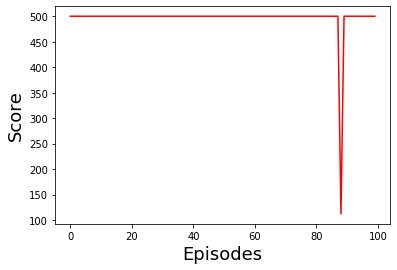

In [34]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(100), scores_arr, 'r')
plt.xlabel('Episodes', fontsize=18)
plt.ylabel('Score', fontsize=18)
plt.savefig('evaluation.png')